In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#######
IN_DATA_FNAMES = ['/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_%d.pkl'%(i) for i in range(1,51)]
import warnings
warnings.filterwarnings("ignore")
#####

In [3]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [4]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib
from tqdm import trange, tqdm

In [5]:
print("Map properties")

# number of pixels for the flat map
nX = 800 
nY = 800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 51  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [6]:
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

L = np.arange(unlensedCL.shape[0])

unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK = interp1d(L, rawKK, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)


ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)


L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi

fTgradT = interp1d(L, cTgradT, kind='linear', bounds_error=False, fill_value=0.)

../data/input/universe_Planck15/camb/CAMB_outputs.pkl


In [7]:
powers['unlensed_scalar'].shape

(29901, 4)

In [8]:
cl.shape

(30001, 3)

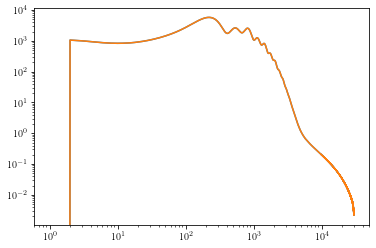

In [9]:
plt.plot(L,list(map(flensedTT,L))*L*(L+1)/(2*np.pi))
plt.plot(np.arange(totCL.shape[0]), totCL[:,0])
plt.xscale('log')
plt.yscale('log')

In [10]:
# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S4/SO specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: ftot(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

In [11]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(fTgradT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


In [12]:
in_data = {}

for fname in tqdm(IN_DATA_FNAMES):
    f = open(fname, 'rb') 
    c_in_data = pickle.load(f) 
    f.close()
    for key in c_in_data:
        if(key != 'kCmbF_1'):
            continue
        if(key not in in_data.keys()):
            in_data[key] = np.array(c_in_data[key])
        else:
            in_data[key] = np.vstack( (in_data[key],np.array(c_in_data[key])) )


for key in in_data:
    print(key, np.shape(in_data[key]))


100%|██████████| 50/50 [00:49<00:00,  1.00it/s]

kCmbF_1 (500, 800, 401)


In [13]:
pairs = [
#    [0,0], #N0
#    [0,1], #kappa
#    [1,0], #kappa
#    [0,2], #N1
#    [1,1], #N1
#    [2,0], #N1
#     [0,3], #should vanish
#     [1,2], #should vanish
#     [2,1], #should vanish
#     [3,0], #should vanish
#     [0,4], #N2 
#     [1,3], #N2
#     [2,2], #N2
#     [3,1], #N2
#     [4,0], #N2
   [-1, -1], #QE
   [-2, -2], #unlensed
]


data_names = {
    0: 'cmb0F_1',
    1: 'lCmbF_o1_1',
    2: 'lCmbF_o2_1',
    3: 'lCmbF_o3_1',
    4: 'lCmbF_o4_1',
    -1: 'lCmbF_1',
    -2: 'totalF_0',
}

In [14]:
nBins=51

In [15]:
data = {}
# pbar = trange(len(pairs))
for file_idx in trange(1,51):
    for pair_idx in range(len(pairs)):
        pair = pairs[pair_idx]
        c_fname = '/oak/stanford/orgs/kipac/users/delon/LensQuEst/estimators_FILE%d_pair_%d_%d.pkl'%(file_idx, pair[0], pair[1])
        if(not os.path.isfile(c_fname)):
            continue
        f = open(c_fname, 'rb')  
        c_data = pickle.load(f)
        f.close()        
        for key in c_data:
            if(key not in data.keys()):
                data[key] = np.array(c_data[key])
            else:
                data[key] = np.vstack((data[key], np.array(c_data[key])))  
#             print(np.shape(data[key]))

100%|██████████| 50/50 [01:13<00:00,  1.46s/it]


In [16]:
for key in data:
    print(key, np.shape(data[key]))

-1-1 (500, 800, 401)
-1-1_sqrtN (500, 800, 401)
-2-2 (500, 800, 401)
-2-2_sqrtN (500, 800, 401)


In [17]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
#     sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    sCls = np.std(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/np.sqrt(n_runs)
    return lCen, Cls, sCls

def combine_sketchy(Cl0, Cli):
    n_runs = np.shape(Cl0)[0]
    print(n_runs, np.shape(Cl0))
    ret = np.copy(Cl0)
    ret = np.transpose(ret, axes=[1,2,0])
    ret[1] = np.array([
        [Cl0[run_idx][1][bin_idx]+
         sum([Cli[i][run_idx][1][bin_idx] for i in range(len(Cli))]) 
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    ret[2] = np.array([[np.sqrt(Cl0[run_idx][2][bin_idx]**2+sum([Cli[i][run_idx][2][bin_idx]**2 
                                                               for i in range(len(Cli))]))
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    return np.transpose(ret, axes=[2,0,1])

In [18]:
ps_data = {}

In [19]:
# #estimate RDN0
# ck = 'RDN(0)'


# for d_idx in trange(len(in_data['kCmbF_1'])):
#     RDN0_fname = '/oak/stanford/orgs/kipac/users/delon/LensQuEst/RDN0-combined-%d-nBins%d.pkl'%(d_idx, nBins)
#     tot = None
#     with open(RDN0_fname,"rb") as f:
#         tot = pickle.load(f)
    
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([tot])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array([tot])))  
# print(ps_data[ck].shape)

In [20]:
# #estimate RDN0
# ck = 'RDN(0) reduced'


# for d_idx in trange(len(in_data['kCmbF_1'])):
#     RDN0_fname = '/oak/stanford/orgs/kipac/users/delon/LensQuEst/RDN0-combined-%d-nBins%d_halved.pkl'%(d_idx, nBins)
#     tot = None
#     with open(RDN0_fname,"rb") as f:
#         tot = pickle.load(f)
    
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([tot])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array([tot])))  
# print(ps_data[ck].shape)

In [21]:
# #estimate RDN0
# ck = 'RDN(0) reduceder'


# for d_idx in trange(len(in_data['kCmbF_1'])):
#     RDN0_fname = '/oak/stanford/orgs/kipac/users/delon/LensQuEst/RDN0-combined-%d-nBins%d_quartered.pkl'%(d_idx, nBins)
#     tot = None
#     with open(RDN0_fname,"rb") as f:
#         tot = pickle.load(f)
    
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([tot])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array([tot])))  
# print(ps_data[ck].shape)

In [22]:
# #estimate N0
# ck = 'N0'

# for data_idx in range(len(data['00'])):
#     q00 = data['00'][data_idx]
#     c_ps_data = {}
#     c_ps_data[ck] = [0,0,0]
#     c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=q00, nBins=15)
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([c_ps_data[ck]])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

In [23]:
# #estimate kk
# ck = 'kk'


# for data_idx in range(min(len(data['01']), len(data['10']))):
#     q01 = data['01'][data_idx]
#     q10 = data['10'][data_idx]
#     kCmbFourier = in_data['kCmbF_1'][data_idx]
#     c_ps_data = {}
#     c_ps_data[ck] = [0,0,0]
#     c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.crossPowerSpectrum(dataFourier1=q10+q01, dataFourier2=kCmbFourier, nBins=nBins)
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([c_ps_data[ck]])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

In [24]:
#estimate <QE QE>
ck = 'QEQE'
for data_idx in trange(len(data['-1-1'])):
    QE = data['-1-1'][data_idx]

    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=QE, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  
print(ps_data[ck].shape)

100%|██████████| 500/500 [00:08<00:00, 60.25it/s]

(500, 3, 50)


In [25]:
print(list(zip(ps_data['QEQE'][0][0], ps_data['QEQE'][0][2] / ps_data['QEQE'][0][1] )))

[(1.1013344570672596, nan), (1.3245407155800113, nan), (1.5929839441335711, nan), (1.9158322703248456, nan), (2.3041119162154526, nan), (2.7710837763192444, nan), (3.3326963162416487, nan), (4.008130259794456, nan), (4.8204536672567055, nan), (5.797409777635384, nan), (6.972364522061591, nan), (8.38544606869786, nan), (10.084915317974428, nan), (12.128814154606884, nan), (14.586947749060446, nan), (17.9775, 0.8164965809277261), (21.098743809438023, nan), (25.424024317562314, 1.0), (30.517487139485507, nan), (35.955, 0.8164965809277261), (40.19891206550247, 0.7071067811865476), (54.54366486810637, 0.4714045207910317), (64.81879805465385, 0.7071067811865476), (75.87368984365843, 0.39223227027636814), (92.20867963356662, 0.36514837167011077), (111.25347122551243, 0.282842712474619), (135.6269589916578, 0.23570226039551587), (160.9113250531605, 0.22086305214969312), (193.36267928864407, 0.1643989873053573), (233.14570205272383, 0.14509525002200235), (278.27034565446087, 0.1212678125181665)

In [26]:
#estimate Nhat
ck = 'Nhat'
for data_idx in trange(len(data['-1-1_sqrtN'])):
    sqrtNhat = data['-1-1_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck],np.array([c_ps_data[ck]])))  
        
print(ps_data[ck].shape)

100%|██████████| 500/500 [00:07<00:00, 67.02it/s]

(500, 3, 50)


In [27]:
#estimate GRF Nhat
ck = 'GRF'
for data_idx in trange(len(data['-2-2_sqrtN'])):
    sqrtNhat = data['-2-2_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack(( ps_data[ck], np.array([c_ps_data[ck]])))  

100%|██████████| 500/500 [00:07<00:00, 66.65it/s]


In [28]:
#estimate <kT kT>
ck = 'kT'

for data_idx in trange(len(in_data['kCmbF_1'])):
    kT = in_data['kCmbF_1'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=kT, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

100%|██████████| 500/500 [00:08<00:00, 59.93it/s]


In [29]:
print(in_data.keys(), data.keys())

dict_keys(['kCmbF_1']) dict_keys(['-1-1', '-1-1_sqrtN', '-2-2', '-2-2_sqrtN'])


In [30]:
#estimate <k kT>
ck = 'kkT'
for data_idx in trange(len(in_data['kCmbF_1'])):
    kT = in_data['kCmbF_1'][data_idx]
    k = data['-1-1'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.crossPowerSpectrum(dataFourier1=k, 
                                                                                      dataFourier2=kT, 
                                                                                      nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

100%|██████████| 500/500 [00:08<00:00, 61.77it/s]


In [31]:
labels={
    'N0':r'$N^{(0)}$',
    'GRF':r'$\hat N$ on GRF',
    'kT': r'$\left<\kappa\kappa\right>$',
    'kk':r'$\left<(\mathcal Q(T^0, T^1)+\mathcal Q(T^1, T^0))\kappa\right>$',
    'kkT':r'$\left<\hat\kappa\kappa\right>$',
    'N1':r'$N^{(1)}$',
    'N2':r'$N^{(2)}$',
    'N2+':r'$N^{(2)}+\dots$',
    'N3+':r'$N^{(3)}+\dots$',
    'RDN(0)':r'${\rm RDN}^{(0)}$',
    'RDN(0)o2':r'${\rm RDN}^{(0)}$',
    'QEQE':r'$\left<\hat\kappa\hat\kappa\right>$',
    'QEQE-Nhat':r'$\left<\hat\kappa\hat\kappa\right>-\hat N$',
    'QEQE-RDN(0)':r"$\left<\hat\kappa\hat\kappa\right>-{\rm RDN}^{(0)}$  [50$s$, 50$s'$]",
    'QEQE-RDN(0) reduced':r"$\left<\hat\kappa\hat\kappa\right>-{\rm RDN}^{(0)}$ [50$s$, 25$s'$]",
    'QEQE-RDN(0) quart':r"$\left<\hat\kappa\hat\kappa\right>-{\rm RDN}^{(0)}$ [25$s$, 25$s'$]",
    'Nhat':r'$\hat N$',
    'N1+':r'$N^{(1)}+\dots$',
    'KK+N1+': r'$\left<(\mathcal Q(T^0, T^1)+\mathcal Q(T^1, T^0))\kappa\right>+N^{(1)}+\dots$',
    'QEQE-2Nhat+Ntheory':r'$\left<\hat\kappa\hat\kappa\right>-2\hat N+N_{\rm theory}$',
    'QEQE-Ntheory':r'$\left<\hat\kappa\hat\kappa\right>-N_{\rm theory}$',
    'QEQE-Ntheory-N1':r'$\left<\hat\kappa\hat\kappa\right>-N_{\rm theory}-N^{(1)}$',
    'QEQE-N0':r'$\left<\hat\kappa\hat\kappa\right>- N^{(0)}$',
    'QEQE-kTkT-Nhat': r'$\left<\hat\kappa\hat\kappa\right>-\left<\kappa\kappa\right>-\hat N$',
    'QEQE-kTkT-Ntheory':r'$\left<\hat\kappa\hat\kappa\right>-\left<\kappa\kappa\right>-N_{\rm theory}$',
    'QEQE-kTkT-RDN(0)':r'$\left<\hat\kappa\hat\kappa\right>-\left<\kappa\kappa\right>-{\rm RDN}^{(0)}$',

}


500 (500, 3, 50)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.96872824 0.         0.96531505
 0.         1.06506386 1.00176179 0.97260719 0.99805483 1.01500233
 1.00897533 1.01612676 1.00052204 0.99790246 1.00531208 0.99580609
 1.00239307 1.00476871 1.0040273  1.00098867 1.00886319 1.00260562
 1.00192701 1.00245223 1.0045307  1.00322445 1.0062644  1.00167987
 1.00606792 1.00440843 1.01068643 1.0052404  0.98177201 0.50711594
 0.         0.        ]


Text(0.5, 0, '$\\ell$')

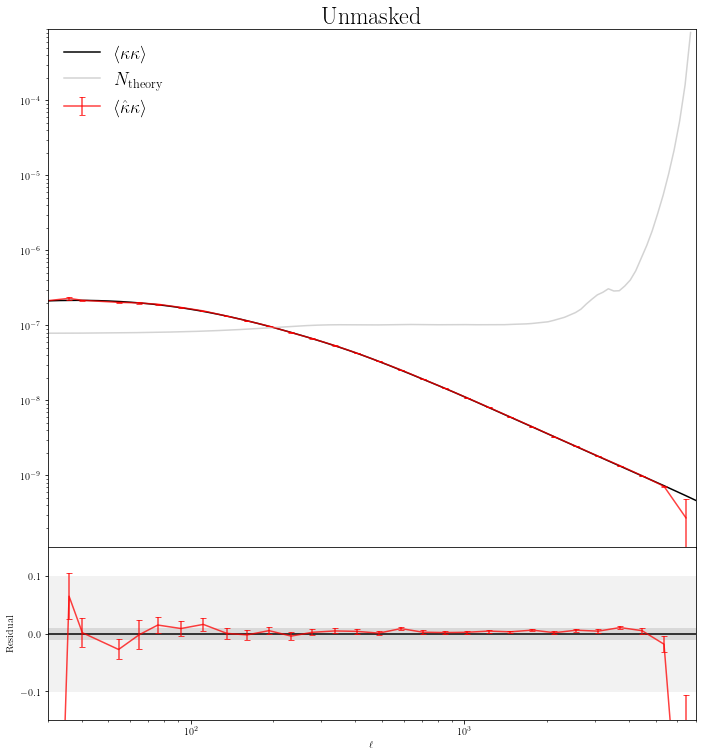

In [32]:
c_keys = ['kkT']
offset=0.03
factor=lambda x:1
pN1 = False
offsets = dict(zip(c_keys,[i*offset for i in range(len(c_keys))]))
colors = dict(zip(c_keys,[plt.colormaps["gist_rainbow"]((i+1)/len(c_keys)) for i in range(len(c_keys))] ))
if(len(c_keys)<=3):
    colors = dict(zip(c_keys, ['red', 'blue', 'green']))

fig = plt.figure(figsize =(12, 12))

axs=[fig.add_axes((0.2,0.2,.75,.6)), fig.add_axes((0.2,0.0,.75,.2))]
ax =axs[0]
res_ax = axs[1]

res_ax.fill_between([0, 1e20], [-0.1, -0.1], [0.1, 0.1], alpha=1, color='0.95')#, label=r'$<10\%$ Error')
res_ax.fill_between([0, 1e20], [-0.01, -0.01], [0.01, 0.01], alpha=1, color='0.85')#, label=r'$<1\%$ Error')
# res_ax.set_yscale('symlog', linthresh=1e3) 
res_ax.set_xscale('log')
res_ax.axhline(0, c='k')
plt.rcParams['text.usetex'] = True

plt.rcParams['font.size'] = 20

ell = baseMap.l.flatten()
theory=[fKK, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    ax.plot(L, factor(L)*ClExpected, sty, label=l)

pN1ax = None
fKK_n1 = None

for key in c_keys:
    lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))

    Cl = factor(lCen)*Cl
    sCl = factor(lCen)*sCl

    offset = offsets[key]
    tmp = [l*np.exp(offset)-l for l in lCen]
    lCen += tmp

    Ipos = np.where(Cl>=1e-30)
    Ineg = np.where(Cl<=-1e-30)

    ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt='-', capsize=3, capthick=1, label=labels[key], c=colors[key])
    tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
#         ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])


    ax.errorbar(lCen[Ineg], -(Cl[Ineg]), yerr=sCl[Ineg], alpha=.75, 
                fmt='--', capsize=3, capthick=1, c=colors[key])
    tmp_data = {
        'x': lCen[Ineg],
        'y1': [y - e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])],
        'y2': [y + e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])]}
#         ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])
    KK = np.array(list(map(fKK,lCen)))

    res_ax.errorbar(lCen, (Cl-KK)/KK, yerr=sCl/KK, alpha=.75, 
                fmt='-', capsize=3, capthick=1, label=labels[key], c=colors[key])
    print((Cl)/KK)
ax.set_title('Unmasked')

ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(1.1e-10,.9e-3)

res_ax.set_xscale('log')
res_ax.set_ylabel(r'Residual')
res_ax.set_xlim(lMin,2*lMax)
res_ax.set_ylim(-.15, .15)

# res_ax.set_yscale('symlog', linthresh=1e-2) 

# res_ax.set_ylim(-.98e0, .98e0)

# if(not pN1):
res_ax.set_xlabel(r'$\ell$')
# else:
#     pN1ax.set_xlabel(r'$\ell$')


In [33]:
def graph_from_keys_legacy(c_keys, offset=0.03, factor=lambda x:1, pN1 = False):
    
    
    offsets = dict(zip(c_keys,[i*offset for i in range(len(c_keys))]))
    colors = dict(zip(c_keys,[plt.colormaps["gist_rainbow"]((i+1)/len(c_keys)) for i in range(len(c_keys))] ))
    if(len(c_keys)<=3):
        colors = dict(zip(c_keys, ['red', 'blue', 'green']))
    fig,ax = plt.subplots(nrows=1, figsize=(10,8))
    plt.rcParams['text.usetex'] = True

    plt.rcParams['font.size'] = 20

    ell = baseMap.l.flatten()
    theory=[fKK, Ntheory]
    theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
    theory_s=['black', 'lightgrey']
    for f,l,sty in zip(theory, theory_l, theory_s):
        L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
        ClExpected = np.array(list(map(f, L)))
        ax.plot(L, factor(L)*ClExpected, sty, label=l)
    
    if(pN1):
        n1 = np.loadtxt('n1_data/N1_All_analytical.dat').T    
        indices = ['TT', 'EE', 'EB', 'TE', 'TB', 'BB']
        bins = n1[0]
        n1_mat = np.reshape(n1[1:], (len(indices), len(indices), len(bins)))
        for i in range(len(indices)):
            if(indices[i] != 'TT'):
                continue        
            n1_pp = (bins*(bins+1))**2/(2*np.pi)*(n1_mat[i][i][:])
            KK = fKK(bins)

            phiphi =  -2. * KK / bins**2
            phiphi *=  -2./ bins**2
            phiphi *= (bins*(bins+1))**2/(2*np.pi) #convention from CAMB 

            pp_n1 = phiphi+n1_pp

            KK_n1 = pp_n1 * 2*np.pi / (bins*(bins+1))**2 #back to our convention
            KK_n1 *= - bins**2 / 2
            KK_n1 *= - bins**2 / 2
            plt.plot(bins, KK_n1, 'k--', label=r'$\big<\kappa\kappa\big>+N^{(1)}$')

    for key in c_keys:
        lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
        Cl = factor(lCen)*Cl
        sCl = factor(lCen)*sCl
        
        offset = offsets[key]
        tmp = [l*np.exp(offset)-l for l in lCen]
        lCen += tmp

        Ipos = np.where(Cl>=1e-30)
        Ineg = np.where(Cl<=-1e-30)

        ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                    fmt='-', capsize=3, capthick=1, label=labels[key], c=colors[key])
        tmp_data = {
            'x': lCen[Ipos],
            'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
            'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
        ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])

        
        ax.errorbar(lCen[Ineg], -(Cl[Ineg]), yerr=sCl[Ineg], alpha=.75, 
                    fmt='--', capsize=3, capthick=1, c=colors[key])
        tmp_data = {
            'x': lCen[Ineg],
            'y1': [y - e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])],
            'y2': [y + e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])]}
        ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])

#         print(lCen[Ineg])
#         print('###########')
#         print(lCen[Ipos])
    ax.set_title('Unmasked')

    ax.legend(frameon=False)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_yscale('log')
    ax.set_xlim(lMin,2*lMax)
    ax.set_ylim(1.1e-10,.9e-3)
    return fig, ax

In [34]:
t0, KK = baseMap.binTheoryPowerSpectrum(fKK, nBins=nBins)

KKsuper = KK 

def graph_from_keys(c_keys, offset=0.03, 
                    factor=lambda x:1, 
                    pN1 = False, 
                    glbl_error=None, 
                    err_ylim=[-1,1],
                    colors = None,
                   pmNtheoryBand = False):
    
    
    offsets = dict(zip(c_keys,[i*offset for i in range(len(c_keys))]))
    if(colors is None):
        colors = dict(zip(c_keys,[plt.colormaps["gist_rainbow"]((i+1)/len(c_keys)) for i in range(len(c_keys))] ))
        if(len(c_keys)<=3):
            colors = dict(zip(c_keys, ['red', 'blue', 'mediumseagreen']))
    
    fig = plt.figure(figsize =(12, 12))

    axs=[fig.add_axes((0.2,0.2,.75,.6)), fig.add_axes((0.2,0.0,.75,.2))]
    ax =axs[0]
    res_ax = axs[1]
    
    res_ax.axhline(0.1, lw=0.5, ls='--', color='k')    
    res_ax.axhline(-0.1, lw=0.5, ls='--', color='k')    

#     res_ax.fill_between([0, 1e20], [-0.1, -0.1], [0.1, 0.1], alpha=1, color='0.95')#, label=r'$<10\%$ Error')
#     res_ax.fill_between([0, 1e20], [-0.01, -0.01], [0.01, 0.01], alpha=1, color='0.85')#, label=r'$<1\%$ Error')
#     res_ax.set_yscale('symlog', linthresh=1e-1) 
    res_ax.set_xscale('log')
    res_ax.axhline(0, c='k', lw=0.5,)
    plt.rcParams['text.usetex'] = True

    plt.rcParams['font.size'] = 20

    ell = baseMap.l.flatten()
    theory=[fKK, Ntheory]
    theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
    theory_s=['black', 'lightgrey']
    for f,l,sty in zip(theory, theory_l, theory_s):
#         L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
#         ClExpected = np.array(list(map(f, L)))
        L, ClExpected= baseMap.binTheoryPowerSpectrum(f, nBins=nBins)
        toPlot = np.where(ClExpected>0)
        ax.plot(L[toPlot], factor(L[toPlot])*ClExpected[toPlot], sty, label=l)
    
    pN1ax = None
    fKK_n1 = None
#     if(pN1):
#         pN1ax = fig.add_axes((0.2, -0.2, .75, .2))
        
#         n1 = np.loadtxt('n1_data/N1_All_analytical.dat').T    
#         indices = ['TT', 'EE', 'EB', 'TE', 'TB', 'BB']
#         bins = n1[0]
#         n1_mat = np.reshape(n1[1:], (len(indices), len(indices), len(bins)))
#         for i in range(len(indices)):
#             if(indices[i] != 'TT'):
#                 continue        
#             n1_pp = (bins*(bins+1))**2/(2*np.pi)*(n1_mat[i][i][:])
#             KK = fKK(bins)

#             phiphi =  -2. * KK / bins**2
#             phiphi *=  -2./ bins**2
#             phiphi *= (bins*(bins+1))**2/(2*np.pi) #convention from CAMB 

#             pp_n1 = phiphi+n1_pp

#             KK_n1 = pp_n1 * 2*np.pi / (bins*(bins+1))**2 #back to our convention
#             KK_n1 *= - bins**2 / 2
#             KK_n1 *= - bins**2 / 2
            
#             fKK_n1 = interp1d(bins, KK_n1, kind='linear', bounds_error=False, fill_value=0.)
#             ax.plot(bins, KK_n1, 'k--', label=r'$\big<\kappa\kappa\big>+N^{(1)}$')

    if(pN1):
        n1 = np.loadtxt('n1_data/N1_All_analytical.dat').T    
        indices = ['TT', 'EE', 'EB', 'TE', 'TB', 'BB']
        bins = n1[0]
        n1_mat = np.reshape(n1[1:], (len(indices), len(indices), len(bins)))
        n1_pp = n1_mat[0][0][:]
        n1_pp *= -bins**2/2
        n1_pp *= -bins**2/2
        fN1 = interp1d(bins, n1_pp, kind='linear', bounds_error=False, fill_value=0.)
        t0, t1 = baseMap.binTheoryPowerSpectrum(fN1, nBins=nBins)
        t2 = np.zeros_like(t1)
        
    for key in reversed(c_keys):
        lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
        assert(all(lCen == t0))

        if(pN1):
            Cl-= t1
            
        Cl = factor(lCen)*Cl
        if(glbl_error is not None):
            _, _, sCl = combine_Cl(np.array(ps_data[glbl_error]))
        sCl = factor(lCen)*sCl
        
        offset = offsets[key]
        tmp = [l*np.exp(offset)-l for l in lCen]
        lCen += tmp

        Ipos = np.where(Cl>=1e-30)
        Ineg = np.where(Cl<=-1e-30)
        c_label = labels[key]
        if(pN1):
            c_label += r'$-N^{(1)}$'
        if('RDN' in key):
            sCl = np.zeros_like(sCl)
            ax.plot(lCen[Ipos], (Cl[Ipos]), alpha=0.75, label=c_label, c=colors[key])
            res_data = (Cl-KK)/KK
            plt_idxs = np.where(lCen<=3500)
            res_ax.plot(lCen[plt_idxs], res_data[plt_idxs], alpha=0.75, c=colors[key]) #label=c_label, 
        else:
            ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=0.75, 
                        fmt='-', capsize=3, capthick=1, label=c_label, c=colors[key])
        
            ax.errorbar(lCen[Ineg], -(Cl[Ineg]), yerr=sCl[Ineg], alpha=0.75, 
                        fmt='--', capsize=3, capthick=1, c=colors[key])

        
        
        
            res_data = (Cl-KK)/KK
            plt_idxs = np.where(lCen<=3500)
            res_ax.errorbar(lCen[plt_idxs], res_data[plt_idxs], yerr=sCl[plt_idxs]/KK[plt_idxs], alpha=0.75, 
                        fmt='-', capsize=3, capthick=1, c=colors[key]) #label=c_label, 
        
        if(pmNtheoryBand and key=='QEQE-Ntheory'):
            lCenSuper, y1, _ = combine_Cl(np.array(Ntheory_super))
            lCenSuper, y2, _ = combine_Cl(np.array(Ntheory_super))

            
            y2=(y2)/KKsuper
            y1=(y1)/KKsuper
            res_ax.fill_between(x=lCenSuper, y1=-0.01*y1, y2=0.01*y2, alpha=1,
                               color='0.95', label=r'$\Delta N^{\rm theory} = 1\%$')
            
            
            res_ax.fill_between(x=lCenSuper, y1=-0.001*y1, y2=0.001*y2, alpha=1,
                               color='0.85', label=r'$\Delta N^{\rm theory} = 0.1\%$')

            res_ax.legend(frameon=False)
#         if(pN1):
#             pN1ax.fill_between([0, 1e20], [-0.1, -0.1], [0.1, 0.1], alpha=1, color='0.95')#, label=r'$<10\%$ Error')
#             pN1ax.fill_between([0, 1e20], [-0.01, -0.01], [0.01, 0.01], alpha=1, color='0.85')#, label=r'$<1\%$ Error')
# #             pN1ax.set_yscale('symlog', linthresh=1e-1) 
#             pN1ax.set_xscale('log')
#             pN1ax.axhline(0, c='k')
#             pN1ax.set_xscale('log')
#             pN1ax.set_ylabel(r'Residual to $+N^{(1)}$')
#             pN1ax.set_xlim(lMin,2*lMax)
#             pN1ax.set_ylim(-.3, .3)
    
#             KKN1 = np.array(list(map(fKK_n1, lCen-tmp)))
#             pN1ax.errorbar(lCen, (Cl-KKN1)/KKN1, yerr=sCl/KK, alpha=0.75, 
#                     fmt='-', capsize=3, capthick=1, label=labels[key], c=colors[key])
#         print(lCen[Ineg])
#         print('###########')
#         print(lCen[Ipos])
    ax.set_title('Unmasked')

    ax.legend(frameon=False)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_yscale('log')
    ax.set_xlim(lMin+2,4800)
    ax.set_ylim(1.1e-9,.9e-6)
    
    res_ax.set_xscale('log')
    res_ax.set_ylabel(r'Frac. Residual')
    res_ax.set_xlim(lMin+2,4800)
    res_ax.set_yticks([-1,-.5,-.1,.1,.5,1])
    res_ax.set_ylim(err_ylim[0], err_ylim[1])
#     if(not pN1):
    res_ax.set_xlabel(r'$\ell$')
#     else:
#         pN1ax.set_xlabel(r'$\ell$')
    return fig, ax

In [35]:
ps_data['QEQE-Nhat'] = combine_sketchy(ps_data['QEQE'], [-ps_data['Nhat']])

500 (500, 3, 50)


In [36]:
asdf1, asdf2 = baseMap.binTheoryPowerSpectrum(Ntheory, nBins=nBins)
asdf3 = np.zeros_like(asdf1)
Ntheory_super = np.array([[asdf1, asdf2, asdf3]])



In [37]:
Ntheory_super.shape

(1, 3, 50)

In [38]:
# import numpy as np
# from multiprocessing import Pool
# from tqdm import trange

# # Define a function to compute Ntheory_evaled for a given iteration
# def compute_Ntheory_evaled(_):
#     # Replace your original code here
#     t0, t1 = baseMap.binTheoryPowerSpectrum(Ntheory, nBins=nBins)
#     t2 = np.zeros_like(t1)
#     return [t0, t1, t2]

# # Set the number of iterations for parallel processing
# num_iterations = ps_data['QEQE'].shape[0]

# # Create a pool of worker processes using all available CPU cores
# pool = Pool()

# # Use the map function to parallelize the computation of Ntheory_evaled
# Ntheory_evaled = list(tqdm(pool.imap(compute_Ntheory_evaled, range(num_iterations)), total=num_iterations))

# # Convert the list of results to a NumPy array
# Ntheory_evaled = np.array(Ntheory_evaled)

# # Clean up the pool of worker processes
# pool.close()
# pool.join()

Ntheory_evaled = np.array([
    [asdf1, asdf2, asdf3] for _ in range(len(ps_data['QEQE']))
])
# Continue with your original code
ps_data['QEQE-Ntheory'] = combine_sketchy(ps_data['QEQE'], [-Ntheory_evaled])

500 (500, 3, 50)


In [39]:
Ntheory_evaled.shape

(500, 3, 50)

In [40]:
ps_data['QEQE-.99Ntheory'] = combine_sketchy(ps_data['QEQE'], [(-.99)*Ntheory_evaled])
ps_data['QEQE-1.01Ntheory'] = combine_sketchy(ps_data['QEQE'], [-1.01*Ntheory_evaled])

ps_data['QEQE-1.001Ntheory'] = combine_sketchy(ps_data['QEQE'], [-1.001*Ntheory_evaled])
ps_data['QEQE-.999Ntheory'] = combine_sketchy(ps_data['QEQE'], [-.999*Ntheory_evaled])


ps_data['QEQE-.99Ntheory'] = combine_sketchy(ps_data['QEQE'], [(-.99)*Ntheory_evaled])
ps_data['QEQE-1.01Ntheory'] = combine_sketchy(ps_data['QEQE'], [-1.01*Ntheory_evaled])

ps_data['QEQE-1.001Ntheory'] = combine_sketchy(ps_data['QEQE'], [-1.001*Ntheory_evaled])
ps_data['QEQE-.999Ntheory'] = combine_sketchy(ps_data['QEQE'], [-.999*Ntheory_evaled])


500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)


In [41]:
# # Continue with your original code
# ps_data['QEQE-Ntheory'] = combine_sketchy(ps_data['QEQE'], [-ps_data['GRF']])

In [42]:
Ntheory_evaled.shape

(500, 3, 50)

In [43]:
f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/ps_data_unmasked_TgradT_weights.pkl', 'wb') 
pickle.dump(ps_data, f)
f.close()

In [44]:
f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/ps_data_unmasked_TgradT_weights.pkl', 'rb') 
ps_data = pickle.load(f)
f.close()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


500 (500, 3, 50)
500 (500, 3, 50)
[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan  2.78358098e-04
             nan  1.22415081e-05             nan -1.44754364e-04
  5.49893619e-05  2.01856320e-04 -3.63093553e-04 -1.39969334e-05
  2.93243740e-04  1.37515056e-04  2.11709923e-04  3.34851843e-04
  3.26845005e-04  2.90544537e-04  3.14194584e-04  2.48671050e-04
  2.16796213e-04  2.09005539e-04  2.73396383e-04  2.39849646e-04
  2.21105901e-04  2.02378293e-04  1.65595743e-04  1.92310688e-04
  3.20296759e-04  5.47665339e-04  6.77372084e-04  2.24389406e-04
  5.77017468e-04 -6.71610360e-05  2.63942934e-04            -inf
            -inf            -inf]


(-0.98, 0.98)

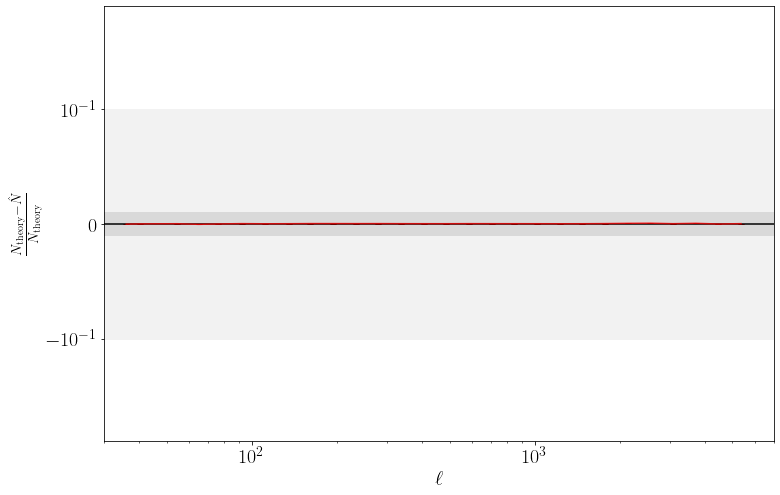

In [45]:
offset=0

fig, ax = plt.subplots(nrows=1, ncols=1, figsize =(12,8))


plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20

ell = baseMap.l.flatten()

lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['GRF']))
lCen1, Cl1, sCl1 = combine_Cl(Ntheory_evaled)

print((Cl0-Cl1)/Cl0)
assert(all(lCen0 == lCen1))
ax.errorbar(lCen0, (Cl0-Cl1)/(Cl0), yerr=sCl1/Cl0, alpha=0.75, 
            fmt='-', capsize=3, capthick=1, c='red')#, label=labels[key], c=colors[key])
# ax.set_title('Masked')

ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\frac{N_{\rm theory} - \hat N}{N_{\rm theory}}$')

ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
# ax.set_ylim(1.1e-10,.9e-3)

ax.fill_between([0, 1e20], [-0.1, -0.1], [0.1, 0.1], alpha=1, color='0.95')#, label=r'$<10\%$ Error')
ax.fill_between([0, 1e20], [-0.01, -0.01], [0.01, 0.01], alpha=1, color='0.85')#, label=r'$<1\%$ Error')
ax.set_yscale('symlog', linthresh=1e-1) 

ax.axhline(0, c='k')

ax.set_ylim(-.98e0, .98e0)
# plt.savefig('figures/mNhat_vs_mNtheory_masked.pdf', bbox_inches='tight')

In [46]:

# graph_from_keys([  
#     'RDN(0)',
#     'Nhat',
# ], offset=0.00)



In [47]:
# ps_data['QEQE-RDN(0)'] = combine_sketchy(ps_data['QEQE'], [-ps_data['RDN(0)']])
# ps_data['QEQE-RDN(0) reduced'] = combine_sketchy(ps_data['QEQE'], [-ps_data['RDN(0) reduced']])
# ps_data['QEQE-RDN(0) quart'] = combine_sketchy(ps_data['QEQE'], [-ps_data['RDN(0) reduceder']])

500 (500, 3, 50)


(<Figure size 720x576 with 1 Axes>,
 <Axes: title={'center': 'Unmasked'}, xlabel='$\\ell$'>)

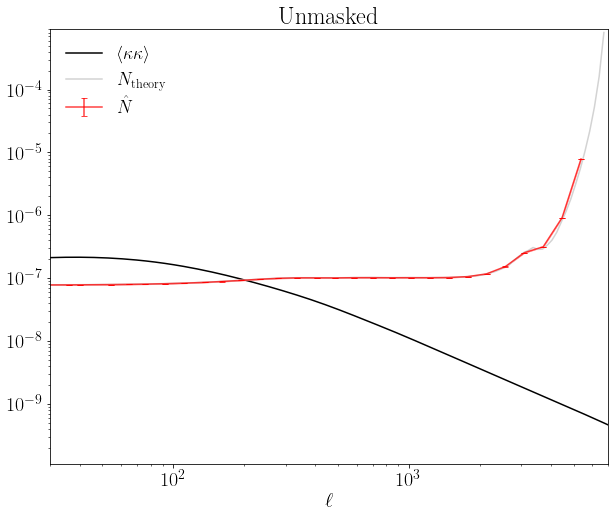

In [48]:
graph_from_keys_legacy([
    'Nhat'
], offset=0.00)#, pN1=True)

In [49]:
# graph_from_keys([
# #     'QEQE-N0',
#     'QEQE-RDN(0)',
#     'QEQE-RDN(0) reduced',
# #     'RDN(0)o2'
# #     'QEQE-2Nhat+Ntheory',
# ], offset=0.03, err_ylim=[-1.2,1.2])#, pN1=True)
# # plt.savefig('figures/mNhat_vs_mNtheory_TgradT_weights.pdf', bbox_inches='tight')


In [50]:
# graph_from_keys([
# #     'QEQE-N0',
#     'QEQE-RDN(0)',
#     'QEQE-RDN(0) reduced',
#     'QEQE-RDN(0) quart',
# #     'RDN(0)o2'
# #     'QEQE-2Nhat+Ntheory',
# ], offset=0.015, pN1=True, glbl_error='QEQE-Ntheory', err_ylim=[-1.5,1.5])
# plt.savefig('figures/mRDN0_vs_mRDN0Reduced_TgradT_weights_pN1.pdf', bbox_inches='tight')

In [51]:
# graph_from_keys([
# #     'QEQE-N0',
#     'QEQE-Ntheory',
#     'QEQE-Nhat',
#     'QEQE-RDN(0)',
# #     'QEQE-RDN(0) reduced',
# #     'QEQE-RDN(0) quart',
# #     'RDN(0)o2'
# #     'QEQE-2Nhat+Ntheory',
# ], offset=0.03)#, pN1=True)
# # plt.savefig('figures/mNhat_vs_mNtheory_TgradT_weights.pdf', bbox_inches='tight')

500 (500, 3, 50)
1 (1, 3, 50)
1 (1, 3, 50)
500 (500, 3, 50)


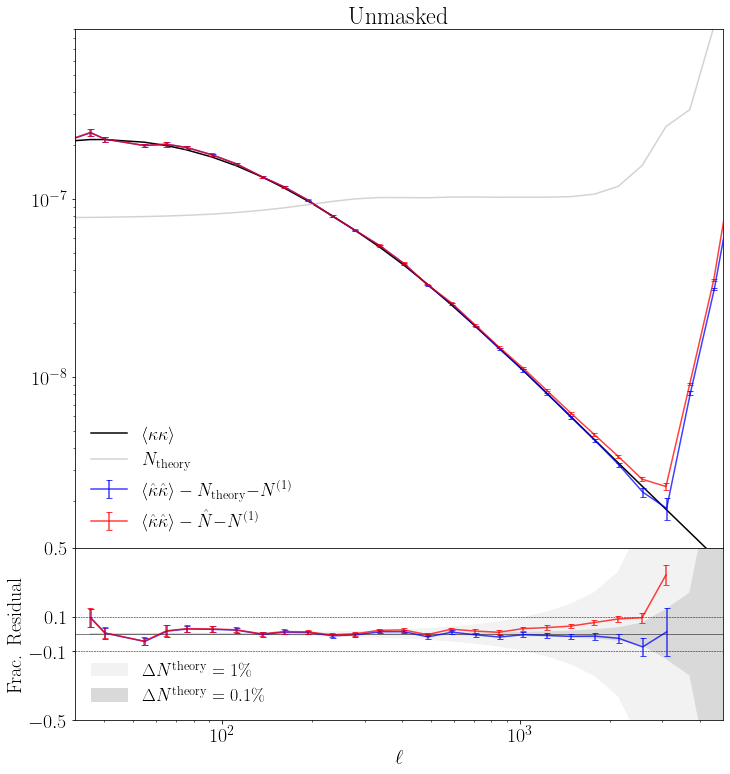

In [52]:
graph_from_keys([
#     'QEQE-N0',
    'QEQE-Nhat',
    'QEQE-Ntheory',
#     'QEQE-RDN(0)',
#     'QEQE-RDN(0) reduced',
#     'QEQE-RDN(0) quart',
#     'RDN(0)o2'
#     'QEQE-2Nhat+Ntheory',
], offset=0.005, 
    pN1=True, 
    colors={'QEQE-Nhat':'red', 
            'QEQE-Ntheory':'blue', 
#             'QEQE-RDN(0) quart':'#98f5b6', 
#             'QEQE-RDN(0) reduced':'#33d3a7',
#             'QEQE-RDN(0)': '#0995ad'
           },
    err_ylim=[-0.5,0.5],
pmNtheoryBand=True)
plt.savefig('figures/mNhat_vs_mNtheory_TgradT_weights_pN1.pdf', bbox_inches='tight')

In [53]:
# graph_from_keys([
# #     'QEQE-N0',
#     'QEQE-Nhat',
#     'QEQE-Ntheory',
# #     'QEQE-RDN(0)',
# #     'RDN(0)o2'
# #     'QEQE-2Nhat+Ntheory',
# ], offset=0.015, 
#     pN1=True, 
#     glbl_error='QEQE-Ntheory',
# pmNtheoryBand=False)
# plt.savefig('figures/mNhat_vs_mNtheory_TgradT_weights_pN1_woNtheorybands.pdf', bbox_inches='tight')

In [ ]:
graph_from_keys_legacy([
    'GRF',
], offset=0.00)
# plt.savefig('figures/Nhat on GRF TgradT.pdf', bbox_inches='tight')

In [ ]:
nBins=15
ps_data = {}

#estimate RDN0
ck = 'RDN(0)'


for d_idx in trange(len(in_data['kCmbF_1'])):
    RDN0_fname = '/oak/stanford/orgs/kipac/users/delon/LensQuEst/RDN0-combined-%d-nBins%d.pkl'%(d_idx, nBins)
    tot = None
    with open(RDN0_fname,"rb") as f:
        tot = pickle.load(f)
    
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([tot])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([tot])))  
print(ps_data[ck].shape)

# #estimate N0
# ck = 'N0'

# for data_idx in range(len(data['00'])):
#     q00 = data['00'][data_idx]
#     c_ps_data = {}
#     c_ps_data[ck] = [0,0,0]
#     c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=q00, nBins=15)
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([c_ps_data[ck]])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  



# #estimate kk
# ck = 'kk'


# for data_idx in range(min(len(data['01']), len(data['10']))):
#     q01 = data['01'][data_idx]
#     q10 = data['10'][data_idx]
#     kCmbFourier = in_data['kCmbF_1'][data_idx]
#     c_ps_data = {}
#     c_ps_data[ck] = [0,0,0]
#     c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.crossPowerSpectrum(dataFourier1=q10+q01, dataFourier2=kCmbFourier, nBins=nBins)
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([c_ps_data[ck]])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

#estimate <QE QE>
ck = 'QEQE'
for data_idx in trange(len(data['-1-1'])):
    QE = data['-1-1'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=QE, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

#estimate Nhat
ck = 'Nhat'
for data_idx in trange(len(data['-1-1_sqrtN'])):
    sqrtNhat = data['-1-1_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck],np.array([c_ps_data[ck]])))  

#estimate GRF Nhat
ck = 'GRF'
for data_idx in trange(len(data['-2-2_sqrtN'])):
    sqrtNhat = data['-2-2_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack(( ps_data[ck], np.array([c_ps_data[ck]])))  

#estimate <kT kT>
ck = 'kT'

for data_idx in trange(len(in_data['kCmbF_1'])):
    kT = in_data['kCmbF_1'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=kT, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

import numpy as np
from multiprocessing import Pool
from tqdm import trange

# Define a function to compute Ntheory_evaled for a given iteration
def compute_Ntheory_evaled(_):
    # Replace your original code here
    t0, t1 = baseMap.binTheoryPowerSpectrum(Ntheory, nBins=nBins)
    t2 = np.zeros_like(t1)
    return [t0, t1, t2]

# Set the number of iterations for parallel processing
num_iterations = 500

# Create a pool of worker processes using all available CPU cores
pool = Pool()

# Use the map function to parallelize the computation of Ntheory_evaled
Ntheory_evaled = list(tqdm(pool.imap(compute_Ntheory_evaled, range(num_iterations)), total=num_iterations))

# Convert the list of results to a NumPy array
Ntheory_evaled = np.array(Ntheory_evaled)

# Clean up the pool of worker processes
pool.close()
pool.join()

# Continue with your original code
ps_data['QEQE-Ntheory'] = combine_sketchy(ps_data['QEQE'], [-Ntheory_evaled])

In [ ]:
f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/ps_data_unmasked_fewer_bins.pkl', 'wb') 
pickle.dump(ps_data, f)
f.close()


In [ ]:
#bandaid
ll = ['%d'%l for l in ps_data['QEQE'][0][0]]
#
def corr2(corr_nhat1, 
          corr_nhat2, 
          filename_base, 
          cmap='seismic', 
          cmap2='seismic', 
          label='', 
          label2=''):
    
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['text.usetex'] = True

    plt.rcParams['font.size'] = 20
    plt.rcParams['text.latex.preamble'] = r'\usepackage{xcolor}'
    plt.rcParams['text.latex.preamble'] +='\n'
#     plt.rcParams['text.latex.preamble'] += r'\definecolor{c1}{rgb}{%.1f,%.1f,%.1f}'%(cmap[3][0],cmap[3][1],cmap[3][2])
#     plt.rcParams['text.latex.preamble'] +='\n'
#     plt.rcParams['text.latex.preamble'] +=r'\definecolor{c2}{rgb}{%.1f,%.1f,%.1f}'%(cmap2[3][0],cmap2[3][1],cmap2[3][2])

    
    corr_nhat = np.copy(corr_nhat1)
    sze = len(corr_nhat1)
    mask = np.array([[0 for _ in range(sze)] for _ in range(sze)])
    for i in range(sze-1):
        for j in range(sze-1-i):
            corr_nhat[i][sze-j-1] = corr_nhat2[i][sze-j-1]
            mask[i][sze-j-1] = 1
    plt.figure(figsize=(25,20))
    print(np.shape(corr_nhat))
    print(np.shape(mask))
    
    ax = sns.heatmap(corr_nhat,  cmap=cmap, cbar=True, vmin=-1, vmax=1, square=True,
                    cbar_kws={ 'ticks':[],
                              "orientation": "horizontal", 'pad':-0.17, 'shrink':0.3})
    
    sns.heatmap(corr_nhat, mask=mask, cmap=cmap2, cbar=True, ax=ax, vmin=-1, vmax=1,square=True,label=label,
           cbar_kws={'label': r"$\rho$","orientation": "horizontal", 'pad':0.1,  'shrink':0.3})
    

    ax.tick_params(axis=u'x', which=u'both',labelrotation=90)
    ax.set_xticks(np.arange(len(ll))+0.5, labels=ll)
    plt.xlabel(r'$\ell$'+'\n')

#     ax.legend(frameon=False)

    ax.tick_params(axis=u'y', which=u'both',labelrotation=0)
    ax.set_yticks(np.arange(len(ll))+0.5, labels=ll)
    plt.ylabel(r'$\ell$'+'\n')

    plt.title(r'Correlations for {%s} (Top Left) and {%s} (Bottom Right)'%(label, label2))
    plt.xlim(4, len(ll)-1)
    plt.ylim(4, len(ll)-1)

    plt.savefig('figures/corr_%s_TgradT_weights.pdf'%(filename_base), bbox_inches='tight')#, use='pgf')


def corr_gen(keys, filename_base):
    Cls_tmp = np.array([None, None])
    for key,idx in zip(keys, range(2)):
        print(np.shape(ps_data[key]))
        Cls_tmp[idx] = np.transpose(np.copy(np.array(ps_data[key])), axes=[1,2,0])[1]

    corrs = np.array([[[(np.corrcoef(Cls_tmp[i][i1], Cls_tmp[i][i2])[1,0])
                          for i1 in range(len(Cls_tmp[i]))]
                         for i2 in range(len(Cls_tmp[i]))]
                         for i in range(2)])

    corr2(corrs[0], corrs[1], 
          label= labels[keys[0]],
         label2=labels[keys[1]], 
         filename_base=filename_base)

In [ ]:
# corr_gen(['QEQE', 'N0'], 'QEQEvsN0')

In [ ]:
ps_data['QEQE-kTkT-Nhat'] = combine_sketchy(ps_data['QEQE'], [-ps_data['kT'],-ps_data['Nhat']])
ps_data['QEQE-kTkT-Ntheory'] = combine_sketchy(ps_data['QEQE'], [-ps_data['kT'],-Ntheory_evaled])
ps_data['QEQE-kTkT-RDN(0)'] = combine_sketchy(ps_data['QEQE'], [-ps_data['kT'],-ps_data['RDN(0)']])

In [ ]:
corr_gen(['QEQE-kTkT-Nhat', 'QEQE-kTkT-Ntheory'], 'mNhat_v_mNtheory')

In [ ]:
corr_gen(['QEQE-kTkT-Nhat', 'QEQE-kTkT-RDN(0)'], 'mNhat_v_mRDN0')